In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc

from sys import path
from os.path import abspath
path.append(abspath("/home/ng136/nico"))
import ng_functions as ng

from glob import glob
from pathlib import Path
import warnings
from time import time
from tqdm import tqdm
from datetime import datetime

## Load datasets

In [3]:
n_states = ['N1a', 'N1b', 'N2', 'N3', 'N4', 'N5', 'N6']

## Zilionis

In [4]:
zdata = sc.read('/n/groups/klein/nico/neutrophils/backups/zilionis_mouse_reannotated_15939x27045_backup_220323_16h11.h5ad')

In [5]:
zdata.X = zdata.layers['cp10k'].copy()

In [6]:
zdata = zdata[zdata.obs['state_label'].isin(n_states)].copy()

## Gungabeesoon

## Untreated

In [8]:
ndata = sc.read("/n/groups/klein/nico/neutrophils/backups/totalseq_exp2_neutrophils_untreated_annotated_embedding_5258x13126_backup_220422_15h46.h5ad")
ndata.layers['umi'] = ndata.X.copy()
ndata.X = ndata.layers['cp10k'].copy()

In [9]:
ndata.obs['N_label'] = ndata.obs['smoothed_Zilionis']

In [10]:
ndata = ndata[ndata.obs['sample_condition'].isin(['KP19', 'KP19_CD101'])].copy()

## Treated

In [11]:
tdata = sc.read("/n/groups/klein/nico/neutrophils/backups/totalseq_exp3_neutrophils_acd40_annotated_embedding_25210x17824_backup_220422_15h46.h5ad")
tdata.layers['umi'] = tdata.X.copy()
tdata.X = tdata.layers['cp10k'].copy()

In [12]:
tdata.obs['N_label'] = tdata.obs['smoothed_Zilionis']

## Garris

In [13]:
gdata = sc.read('/n/groups/klein/nico/neutrophils/data/rss_marius/adata_garris_neu_12012020.h5ad')
gdata = gdata[gdata.obs['res_0.5'] == '4']

In [14]:
gdata.obs['N_label'] = pd.DataFrame(**np.load('/n/groups/klein/nico/neutrophils/backups/loglikelihoods_multinomial_naive_bayes_garris_neutrophils_by_zilionis_reannotated_220614_02h55.npz', allow_pickle=True)).idxmax(0).values

Trying to set attribute `.obs` of view, copying.


In [15]:
gdata_nt = gdata[gdata.obs['Treatment'] == 'Control'].copy()
gdata_apd1 = gdata[gdata.obs['Treatment'] == 'aPD1'].copy()

## Siwicki

In [16]:
sdata_raw = sc.read("/n/groups/klein/nico/tox/backups/tox_marie_all_cells_unnormalized_pca_umap_leiden_35358x22631_backup_200604_01h08.h5ad")
sdata_raw.obs['label_Zilionis'] = pd.DataFrame(**np.load("/n/groups/klein/nico/tox/backups/loglikelihoods_bay_classif_tox_marie_all_cells_200423_20h42.npz", allow_pickle=True)).idxmax().values
#sdata3 = sdata3[(~sdata3.obs['predicted_doublet']) & (~sdata3.obs['leiden_minor_subset'].isin(['Hepatocytes', 'RBC', 'EC1', 'EC2']))]

sdata = sc.read('/home/ng136/nico/tox/backups/tox_marie_processed_data_with_raw_all_cells_34659x22631_backup_210102_20h25.h5ad')
sdata = sdata[(~sdata.obs['predicted_doublet']) & (~sdata.obs['leiden_minor_subset'].isin(['Hepatocytes', 'RBC', 'EC1', 'EC2']))]
sdata.obs['label_Zilionis'] = sdata_raw.obs['label_Zilionis'].astype('category')
sdata = sdata[sdata.obs['leiden'].isin(['0', '4', '15', '20', '21'])]

sdata.obs['N_label'] = pd.DataFrame(**np.load('/n/groups/klein/nico/neutrophils/backups/loglikelihoods_multinomial_naive_bayes_siwicki_neutrophils_by_zilionis_reannotated_220614_02h56.npz', allow_pickle=True)).idxmax(0).values

/n/groups/klein/nico/amyloidosis/analysis/conda-env/lib/python3.9/site-packages/anndata/compat/__init__.py:180: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/n/groups/klein/nico/amyloidosis/analysis/conda-env/lib/python3.9/site-packages/anndata/compat/__init__.py:180: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


In [17]:
sdata_tumor_nt = sdata[(sdata.obs['treatment'] == 'NT') & (sdata.obs['tissue'] == 'Tumor') & (sdata.obs['marker'] == 'CD45pos')].copy()
sdata_tumor_acd40 = sdata[(sdata.obs['treatment'] == 'Trx') & (sdata.obs['tissue'] == 'Tumor') & (sdata.obs['marker'] == 'CD45pos')].copy()

# Human Zilionis

## Convert human genes through homology database

In [18]:
hom = pd.read_csv('/home/ng136/nico/neutrophils/references/HOM_MouseHumanSequence.rpt', sep='\t')
one_to_one = hom['DB Class Key'].value_counts()[hom['DB Class Key'].value_counts() == 2].index.values
hom = hom[hom['DB Class Key'].isin(one_to_one)]

In [19]:
hom_hs = hom[hom['Common Organism Name'] == 'human']
hom_mm = hom[hom['Common Organism Name'] == 'mouse, laboratory']

In [20]:
hom_hs_dict = {h['Symbol'] : h['DB Class Key'] for _,h in hom_hs.iterrows()}
hom_mm_dict = {h['DB Class Key'] : h['Symbol'] for _,h in hom_mm.iterrows()}
hom_dict = {k : hom_mm_dict[v] for k,v in hom_hs_dict.items()}

## Human (Zilionis)

In [35]:
#Import data from Zilionis et al. (Immunity, 2019)
hdata = sc.read_h5ad('/n/groups/klein/nico/blz/data/adata_zilionis_54773x25_200430_22h27.h5ad')

sc.pp.normalize_per_cell(hdata,counts_per_cell_after=1e4)
hdata = hdata[hdata.obs['Major cell type'] == 'tNeutrophils', :].copy()
hdata.var_names = pd.Series(hdata.var_names).replace({**hom_dict, 'IFIT1':'Ifit1'})

hdata.obs['N_label'] = hdata.obs['state'].map({'zi-tN1':'N1', 'zi-tN2':'N2'}).copy()
hdata.obs.loc[pd.isna(hdata.obs['N_label']),'N_label'] = 'Other'

In [36]:
datasets = {'Gungabeesoon KP19 untreated': ndata,
             'Gungabeesoon KP19 aCD40': tdata,
             'Zilionis NSCLC' : hdata,
             'Garris MC38 untreated': gdata_nt,
             'Garris MC38 aPD1': gdata_apd1,
             'Siwicki MC38 untreated': sdata_tumor_nt,
             'Siwicki MC38 aCD40': sdata_tumor_acd40}

for i in datasets.keys():
    datasets[i].obs['neutrophil_group'] =  datasets[i].obs['N_label'].replace({'N1a': 'Sellhi', 'N1b' :'Sellhi', 'N2':'Sellhi', 'N3':'Cxcl3hi', 'N4' : 'Siglecfhi', 'N5' : 'Siglecfhi', 'N6' : 'Siglecfhi'})

# ISG genes

In [37]:
isg_genes = ['Adar', 'Isg15', 'Isg20', 'Rsad2', 'Ifit1', 'Ifit3', 'Ifitm1', 'Ifitm3', 'Irak1', 'Oas3', 'Stat1', 'Stat2', 'Irf7', 'Cxcl10']

# ISG averages

In [38]:
isg_all_groups = pd.concat([ng.groupby_aggregate(d, groupby='neutrophil_group', var_names= isg_genes, f=np.mean, return_df=True).assign(dataset=dataset_name).reset_index() for dataset_name,d in datasets.items() if dataset_name != 'Zilionis NSCLC'])
isg_all_groups.index = isg_all_groups['neutrophil_group'] +'_'+ isg_all_groups['dataset'].apply(ng.fix_filename)
isg_all_groups = isg_all_groups.drop(['dataset', 'neutrophil_group'], axis=1)

In [39]:
isg_all_states = pd.concat([ng.groupby_aggregate(d, groupby='N_label', var_names= isg_genes, f=np.mean, return_df=True).assign(dataset=dataset_name).reset_index() for dataset_name,d in datasets.items()])
isg_all_states.index = isg_all_states['N_label'] +'_'+ isg_all_states['dataset'].apply(ng.fix_filename)
isg_all_states = isg_all_states.drop(['dataset', 'N_label'], axis=1)

In [40]:
sorted_groups = ['Sellhi_Gungabeesoon_KP19_untreated',
                 'Sellhi_Gungabeesoon_KP19_aCD40', 
                 'Sellhi_Siwicki_MC38_untreated',
                 'Sellhi_Siwicki_MC38_aCD40',
                 'Sellhi_Garris_MC38_untreated',
                 'Sellhi_Garris_MC38_aPD1']

In [41]:
isg_per_group = isg_all_groups.loc[sorted_groups]

In [42]:
isg_kp19_acd40 = isg_all_states.loc[['N1a_Gungabeesoon_KP19_untreated', 'N1b_Gungabeesoon_KP19_untreated', 'N2_Gungabeesoon_KP19_untreated',
                    'N1a_Gungabeesoon_KP19_aCD40', 'N1b_Gungabeesoon_KP19_aCD40', 'N2_Gungabeesoon_KP19_aCD40'],:]

isg_mc38_acd40 = isg_per_group[2:4]
isg_mc38_apd1 = isg_per_group[4:]
isg_nsclc = isg_all_states.loc[['N1_Zilionis_NSCLC','N2_Zilionis_NSCLC'],:]

# Plot heatmap

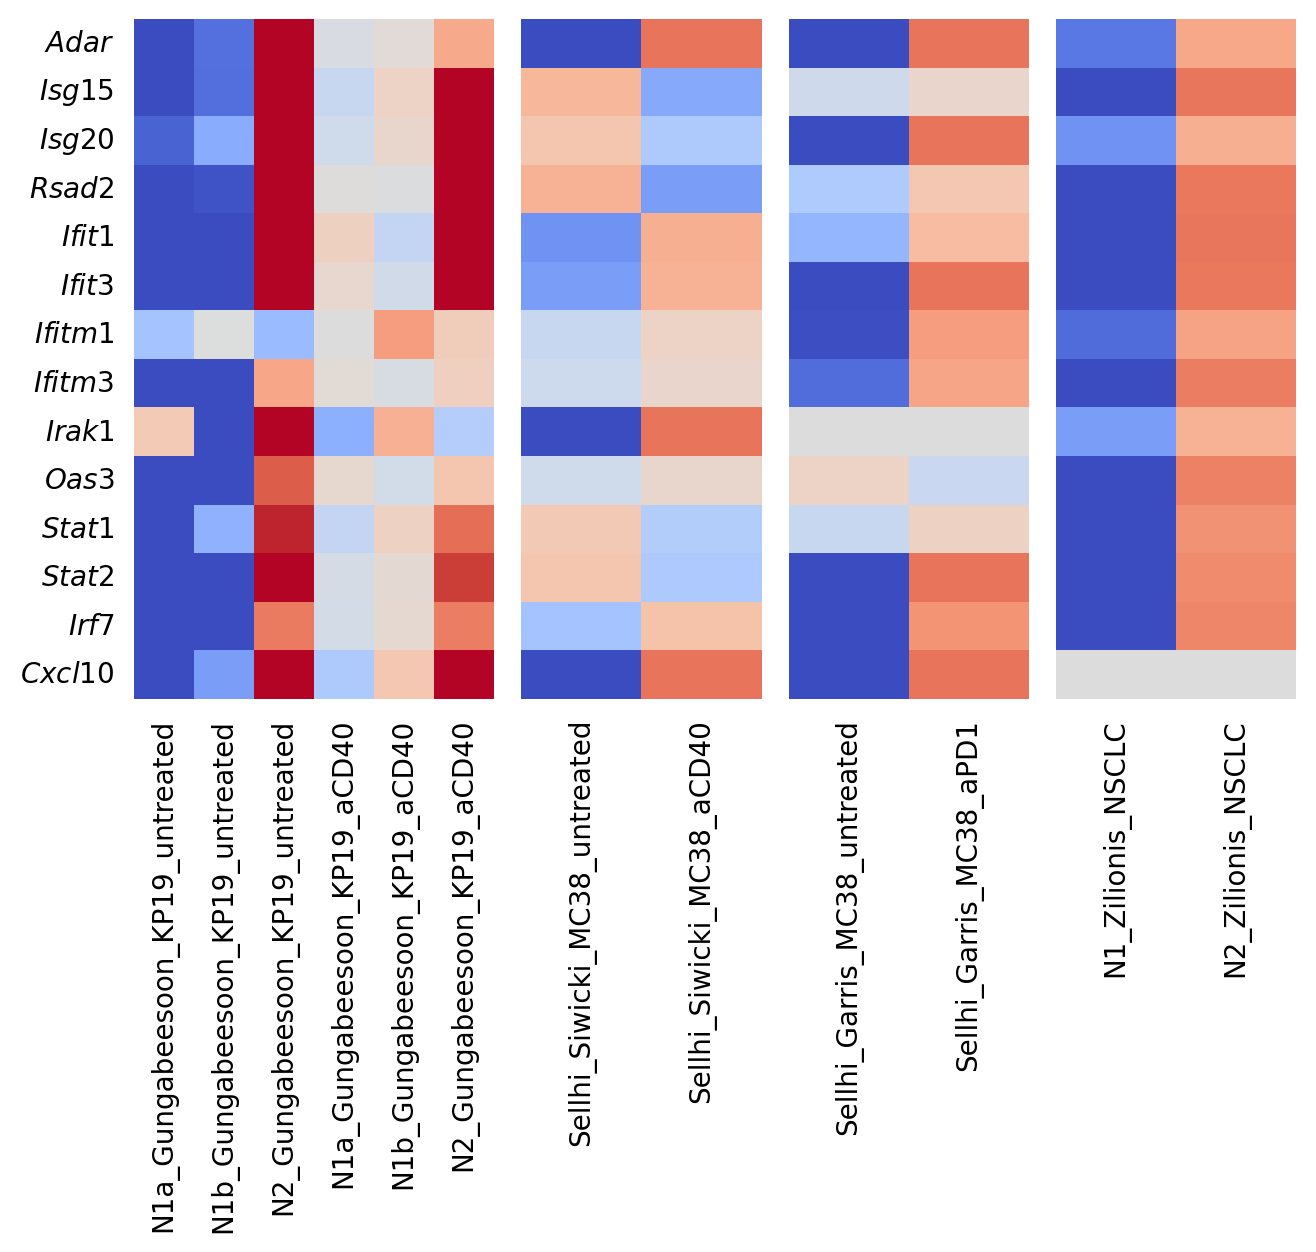

In [58]:
fig, axes = plt.subplots(1,4, sharey=True, dpi=200, gridspec_kw={'width_ratios':(1.5,1,1, 1)}, figsize=(7.5,4.5))

vmin, vmax= (-1.5, 1.5)

epsilon = 0.0001

sns.heatmap(np.log2((isg_kp19_acd40 + epsilon)/ (isg_kp19_acd40.median(0)+epsilon)).T, cmap='coolwarm', ax=axes[0], cbar=False, center=0, vmax=vmax, vmin=vmin)

sns.heatmap(np.log2((isg_mc38_acd40 + epsilon)/ (isg_mc38_acd40.median(0)+epsilon)).T, cmap='coolwarm', ax=axes[1], cbar=False, center=0, vmax=vmax, vmin=vmin)

sns.heatmap(np.log2((isg_mc38_apd1 + epsilon)/ (isg_mc38_apd1.median(0)+epsilon)).T, cmap='coolwarm', ax=axes[2], cbar=False, center=0, vmax=vmax, vmin=vmin)

sns.heatmap(np.log2((isg_nsclc + epsilon)/ (isg_nsclc.median(0)+epsilon)).T, cmap='coolwarm', ax=axes[3], cbar=False, center=0, vmax=vmax, vmin=vmin)

axes[0].set_yticklabels([r'$\it{' + ticklabel.get_text().replace('_', '\\ ') + '}$'
                              for ticklabel in axes[0].get_yticklabels()])

[ax.tick_params(left=False, bottom=False) for ax in axes]

plt.gcf().subplots_adjust(wspace=0.1)

plt.show()